# Oppgave 2 - Klassifikasjon (30%)<a name="oppgave2"></a>

*Oppgave 2 består av 4 deler med til sammen 15 spørsmål, der alle spørsmål (2a.1), 2a.2) etc.) teller likt. Oppgave 2 teller totalt 30 % av prosjektet.*

**Oppgaven inneholder følgende elementer:**

* Laste inn og utforske et datasett for klassifikasjon
* Dele datasettet inn i treningssett, valideringssett og testsett
* Tilpasse en logistisk regresjon og bruke denne til å klassifisere
* Utføre $k$-nærmeste nabo-klassifikasjon
* Evaluere godhet av klassifikasjonsresultatene

## Innholdsfortegnelse
* [Ble det hjemmeseier?](#intro)
* [Oppgave 2a) Lese inn og preprosessere data](#oppgave2a)
* [Oppgave 2b) Logistisk regresjon](#oppgave2b)
* [Oppgave 2c) $k$-nærmeste-nabo-klassifikasjon](#oppgave2c)
* [Oppgave 2d) Evaluere beste modeller](#oppgave2d)


### Ble det hjemmeseier?<a name="intro"></a>

Datasettet vi skal se på er fra de fire øverste divisjonene i engelsk fotball, i sesongen 2022-2023, og oppgaven går ut på å tilpasse ulike metoder for å predikere om hjemmelaget vinner en gitt kamp utifra data på antall skudd på mål, cornere og forseelser (regelbrudd som fører til frispark eller straffespark).

Mer informasjon om dataene: https://www.football-data.co.uk/englandm.php.

In [2]:
# importere pakker og funksjoner vi trenger i oppgave 2
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

### Oppgave 2a) Lese inn og preprosessere data<a name="oppgave2a"></a>

*Oppgave 2a) inneholder 5 spørsmål du skal svare på.*

Datasettet vi skal jobbe med inneholder informasjon om fotballkamper i engelsk fotball. Dataene finnes i fire forskjellige filer, og hver fil inneholder informasjon om kampene i en gitt divisjon. Vi laster inn dataene fra hver fil og kombinerer dem. Etter vi har gjort dette har datasettet $2036$ rader og $106$ kolonner. En gitt rad tilsvarer en gitt kamp og en gitt kolonne tilsvarer en type informasjon (f.eks. antall cornere hjemmelaget hadde). Kolonner som begynner på `H` angår hjemmelaget og `A` angår bortelaget.

I en gitt kamp vinner enten hjemmelaget, eller så vinner ikke hjemmelaget (uavgjort eller borteseier). Resultatet av en kamp er dermed at:
* hjemmelaget vinner - kodet som $1$
* hjemmelaget vinner ikke - kodet som $0$.

Kampresultatet ($0$ eller $1$) legger vi i kolonnen `y`, som skal være hva vi vil predikere/klassifisere.

Vi skal ikke se på alle variablene i datasettet, og skal i tillegg til `y` konsentrere oss om kolonnene

* `HST`, `AST`: antall skudd på mål for henholdsvis hjemmelaget og bortelaget
* `HC`, `AC`: antall cornere for henholdsvis hjemmelaget og bortelaget
* `HF`, `AF`: antall forseelser for henholdsvis hjemmelaget og bortelaget

Istedenfor å se direkte på disse tre antallene for de to lagene, ser vi heller på *differansene* for hver kamp. Vi lager de nye variablene

* `skudd_paa_maal_diff`=`HST`-`AST`
* `corner_diff`=`HC`-`AC`
* `forseelse_diff`=`HF`-`AF`

og dette skal være forklaringsvariablene våre.

_Oppsummert_: Observasjonsenheten i dataene er en fotballkamp, vi har tre forklaringsvariabler `skudd_paa_maal_diff`, `corner_diff` og `forseelse_diff`, mens `y` (0 eller 1) er responsen vi ønsker å predikere.


Koden under leser inn dataene, lager de nye variablene og putter alt inn i en ny data frame. Etter det er gjort har vi en datasett med $2036$ rader (kamper) og $4$ kolonner (variabler).

In [3]:
# Lese inn datasettene ved funksjon fra pandas (df=data frame - vanlig navn å gi et datasett)
df0 = pd.read_csv("https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2023/E0.csv", sep = ',') # Premier League
df1 = pd.read_csv("https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2023/E1.csv", sep = ',') # Championship
df2 = pd.read_csv("https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2023/E2.csv", sep = ',') # League 1
df3 = pd.read_csv("https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2023/E3.csv", sep = ',') # League 2

# Sett sammen datasettene til 1 data-frame
df_in=pd.concat([df0,
                 df1,
                 df2,
                 df3], ignore_index = True)
df=pd.concat([pd.Series(np.where(df_in['FTR'] == 'H', 1, 0)),
              df_in['HST']-df_in['AST'], 
              df_in['HC']-df_in['AC'],
              df_in['HF']-df_in['AF']], axis = 1)

# Henter ut de dataene vi er interessert i
df.columns=['y', 'skudd_paa_maal_diff', 'corner_diff', 'forseelse_diff']
print(df.describe())

                 y  skudd_paa_maal_diff  corner_diff  forseelse_diff
count  2036.000000          2036.000000  2036.000000     2036.000000
mean      0.432711             0.797151     1.003438       -0.549607
std       0.495573             3.324189     4.347722        4.583058
min       0.000000           -11.000000   -17.000000      -17.000000
25%       0.000000            -1.000000    -2.000000       -4.000000
50%       0.000000             1.000000     1.000000        0.000000
75%       1.000000             3.000000     4.000000        2.000000
max       1.000000            12.000000    16.000000       17.000000



Videre vil vi dele datasettet vårt inn i tre datasett: et treningssett, et valideringssett og et testsett. Først deler vi data inn i 80\% trening/validering og 20\% test, og deretter deler vi trening/valideringssettet inn i 75\% trening og 25\% validering.


In [4]:
df_trenval, df_test = train_test_split(df, test_size = 0.2, random_state = 1, stratify = df['y'])
df_tren, df_val = train_test_split(df_trenval, test_size = 0.25, random_state = 1, stratify = df_trenval['y'])
print("treningssett: \n", df_tren.shape)
print(df_tren.describe())
print(df_tren["y"].value_counts())
print("\nvalideringssett: \n", df_val.shape)
print(df_val.describe())
print(df_val["y"].value_counts())
print("\ntestsett: \n", df_test.shape)
print(df_test.describe())
print(df_test["y"].value_counts())

treningssett: 
 (1221, 4)
                 y  skudd_paa_maal_diff  corner_diff  forseelse_diff
count  1221.000000          1221.000000  1221.000000     1221.000000
mean      0.432432             0.933661     1.020475       -0.701065
std       0.495617             3.286039     4.331025        4.601308
min       0.000000           -11.000000   -17.000000      -17.000000
25%       0.000000            -1.000000    -2.000000       -4.000000
50%       0.000000             1.000000     1.000000       -1.000000
75%       1.000000             3.000000     4.000000        2.000000
max       1.000000            12.000000    14.000000       17.000000
y
0    693
1    528
Name: count, dtype: int64

valideringssett: 
 (407, 4)
                y  skudd_paa_maal_diff  corner_diff  forseelse_diff
count  407.000000           407.000000   407.000000      407.000000
mean     0.432432             0.734644     1.002457       -0.324324
std      0.496023             3.345956     4.333112        4.589877
min   

I denne oppgaven skal vi etterhvert tilpasse logistisk regresjon og $k$-nærmeste nabo-klassifikasjon.

**2a.1)** Hvorfor ønsker vi å dele dataene inn i trening-, validering- og test-sett?

**2a.2)** Hvor stor andel av dataene er nå i hver av de tre settene? Ser de tre datasettene ut til å ha lik fordeling for de tre forklaringsvariablene og responsen?

**2a.3)** La oss si at vi hadde valgt League 1 og 2 som treningssett, Championship som valideringssett, og Premier League som testsett. Hvorfor hadde dette vært dumt?

For å utforske dataene lager vi kryssplott av de tre forklaringsvariablene for treningsdataene og fargelegger punktene fra kampene etter hvorvidt det var hjemmeseier eller ikke. På diagonalen ser vi empiriske tetthetsplott (glattet variant av et histogram). Under har vi også regnet ut empirisk korrelasjonskoeffisient for alle par av variabler.

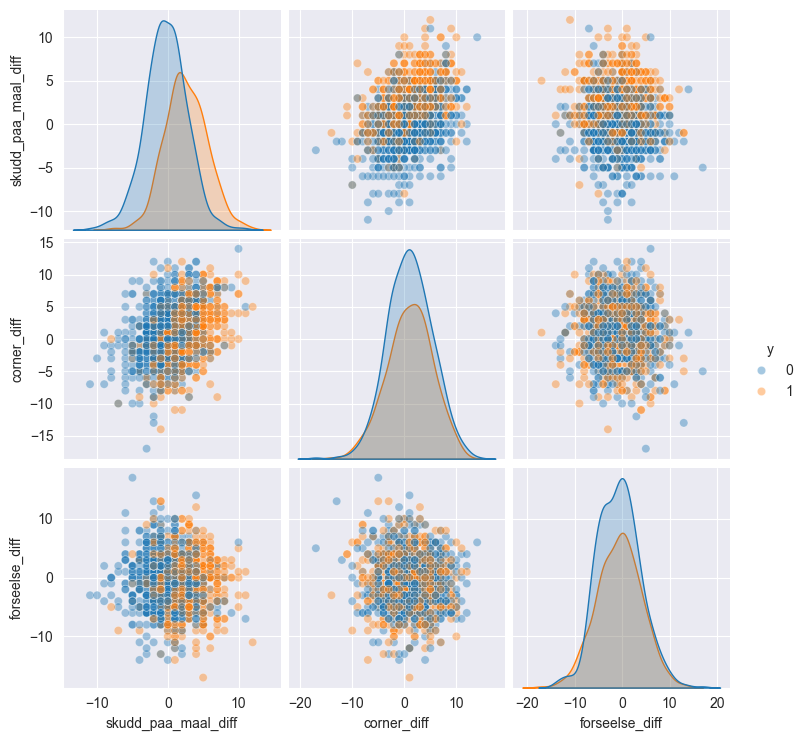

In [13]:
sns.pairplot(df_tren, vars = ['skudd_paa_maal_diff','corner_diff','forseelse_diff'],
             hue = 'y', 
             diag_kind = 'kde',
             plot_kws = dict(alpha = 0.4))
plt.show()

In [6]:
corr = df_tren.corr()
display(corr.style.background_gradient(cmap = 'coolwarm', axis = None, vmin = -1, vmax = 1))
plt.show()

,y,skudd_paa_maal_diff,corner_diff,forseelse_diff
y,1.000000,0.423284,-0.004892,0.007606
skudd_paa_maal_diff,0.423284,1.000000,0.343355,-0.051163
corner_diff,-0.004892,0.343355,1.000000,-0.055752
forseelse_diff,0.007606,-0.051163,-0.055752,1.000000


**2a.4)** Kommenter kort på hva du ser i plottene og utskriften (maks 5 setninger).

**2a.5)** Hvilke(n) av de tre variablene tror du vil være god(e) til å bruke til å predikere om det blir hjemmeseier? Begrunn svaret kort (maks 3 setninger).

### Oppgave 2b) Logistisk regresjon<a name="oppgave2b"></a>

*Oppgave 2b) inneholder 5 spørsmål du skal svare på.*

Vi tilpasser en logistisk regresjon til treningssettet, og regner ut feilrate for valideringssettet gitt at vi klassifiserer som suksess (hjemmeseier) når sannsynligheten for hjemmeseier er anslått til minst 0.5.

Dette gjør vi med de samme stegene som det vi gjorde for multippel lineær regresjon:

1) Bli kjent med dataene ved å se på oppsummeringsmål og ulike typer plott
2) Spesifisere en matematisk modell (modellformel)
3) Initialisere og tilpasse modellen
4) Presentere resultater fra den tilpassede modellen
5) Evaluere om modellen passer til dataene

Vi er ferdige med Steg 1, og gjør så Steg 2-4 under.

In [14]:
# Steg 2: Modellformel
formel = "y ~ skudd_paa_maal_diff + corner_diff + forseelse_diff"

# Steg 3: Initialiser modellen 
modell = smf.logit(formel, data = df_tren)

# Tilpass modellen
resultat = modell.fit()

# Steg 4: Presenter koeffisient-verdier (betaer) fra den tilpassede modellen 
print("\nKoeffisentverdier:\n\n", resultat.params)

Optimization terminated successfully.
         Current function value: 0.567874
         Iterations 6

Koeffisentverdier:

 Intercept             -0.591661
skudd_paa_maal_diff    0.382565
corner_diff           -0.100377
forseelse_diff         0.012009
dtype: float64


**2b.1)** I en kamp der `skudd_paa_maal_diff` er $2$, `corner_diff` er $-2$ og `forseelse_diff` er $6$, hva er ifølge modellen sannsynligheten for at hjemmelaget vinner? Vis utregninger og/eller kode, og oppgi svaret med tre desimaler.

**2b.2)** Hvordan kan du tolke verdien av $e^{\beta_{\texttt{skudd_paa_maal_diff}}}$?

In [25]:
# her kan du skrive kode for å regne ut exp(beta)
np.exp(0)
skudd_paa_maal_diff = 1
result = np.exp(skudd_paa_maal_diff)
print(result)

2.718281828459045


**2b.3)** Hva angir feilraten til modellen? Hvilket datasett er feilraten regnet ut fra? Er du fornøyd med verdien til feilraten?

In [9]:
# Spesifiser verdi for cutoff
cutoff = 0.5

# Prediker verdi for valideringssettet
val_pred = resultat.predict(exog = df_val)

# Klassifiser som seier for hjemmelaget hvis sannsynligheten for at hjemmelaget vant er over 0.5
y_valpred = np.where(val_pred > cutoff, 1, 0)
y_valobs = df_val['y']

# Finn feilrate
print("Feilrate:", 1 - accuracy_score(y_true = y_valobs, y_pred = y_valpred))

Feilrate: 0.28501228501228504


Tilpass nå den logistiske regresjonen uten `forseelse_diff` som forklaringsvariabel - ved å kopiere koden over (men ikke den gamle formelen).

**2b.4)** Diskuter kort hvordan koeffisientene ($\beta$-ene) og feilraten endrer seg når `forseelse_diff` tas ut av modellen (maks 3 setninger).

**2b.5)** Med den nye modellen: I en kamp der `skudd_paa_maal_diff` $= 2$, `corner_diff` $= -2$ og `forseelse_diff` $= 6$, hva er sannsynligheten for at hjemmelaget vinner ifølge den nye modellen? Oppgi svaret med tre desimaler.

**2b.6)** Hvis du skal finne en så god som mulig klassifikasjonsmodell med logistisk regresjon, vil du velge modellen med eller uten `forseelse_diff` som forklaringsvariabel? Begrunn kort svaret (maks 3 setninger).

In [10]:
# her kan du lime inn kode for å svare på 2b.4) til 2b.6)

### Oppgave 2c) $k$-nærmeste-nabo-klassifikasjon<a name="oppgave2c"></a>

*Oppgave 2c) inneholder 2 spørsmål du skal svare på.*

Vi skal nå kun se på forklaringsvariablene `skudd_paa_maal_diff` og `corner_diff`, og tilpasse $k$-nærmeste-nabo-metoden der vi bruker euklidsk avstand som avstandsmål. Vi bruker valideringssettet til å velge $k$.

Koden under tilpasser $k$-nærmeste nabo-klassifikasjon for ulike verdier for $k$, deretter regnes feilrate ut på valideringssettet og plottes.

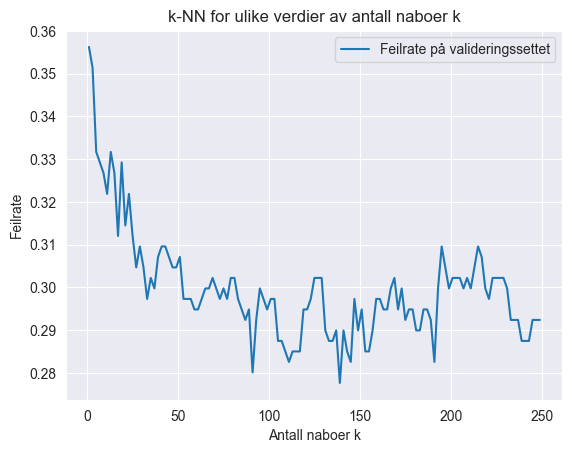

Valideringsfeilrate:
[[  1.           0.35626536]
 [  3.           0.35135135]
 [  5.           0.33169533]
 [  7.           0.32923833]
 [  9.           0.32678133]
 [ 11.           0.32186732]
 [ 13.           0.33169533]
 [ 15.           0.32678133]
 [ 17.           0.31203931]
 [ 19.           0.32923833]
 [ 21.           0.31449631]
 [ 23.           0.32186732]
 [ 25.           0.31203931]
 [ 27.           0.3046683 ]
 [ 29.           0.30958231]
 [ 31.           0.3046683 ]
 [ 33.           0.2972973 ]
 [ 35.           0.3022113 ]
 [ 37.           0.2997543 ]
 [ 39.           0.30712531]
 [ 41.           0.30958231]
 [ 43.           0.30958231]
 [ 45.           0.30712531]
 [ 47.           0.3046683 ]
 [ 49.           0.3046683 ]
 [ 51.           0.30712531]
 [ 53.           0.2972973 ]
 [ 55.           0.2972973 ]
 [ 57.           0.2972973 ]
 [ 59.           0.29484029]
 [ 61.           0.29484029]
 [ 63.           0.2972973 ]
 [ 65.           0.2997543 ]
 [ 67.           0.299

In [57]:
knaboer = np.arange(1, 251, step = 2)
val_feilrate = np.empty(len(knaboer))

X_tren = df_tren[['skudd_paa_maal_diff', 'corner_diff']] # bruker bare disse to forklaringsvariablene
X_val = df_val[['skudd_paa_maal_diff', 'corner_diff']] 

for i,k in enumerate(knaboer):
    
    # Initialiser kNN med  k neighbors
    knn = KNeighborsClassifier(n_neighbors=k, p = 2) # p = 2 gir euklidsk avstand

    # Tilpass modellen med treningssettet
    knn.fit(X_tren, df_tren['y'])
    
    # Beregn feilrate på valideringssett
    # score er accuracy = "andel korrekt"
    val_feilrate[i] = 1 - knn.score(X_val, df_val['y'])
    
# Lage plott
plt.title('k-NN for ulike verdier av antall naboer k')
plt.plot(knaboer, val_feilrate, label = 'Feilrate på valideringssettet')
plt.legend()
plt.xlabel('Antall naboer k')
plt.ylabel('Feilrate')
plt.show()

valres=np.vstack((knaboer, val_feilrate))
print("Valideringsfeilrate:")
print(valres.T)

**2c.1)** Påstand: kNN kan bare brukes når vi har maksimalt to forklaringsvariabler. Fleip eller fakta?

**2c.2)** Hvilken verdi av $k$ vil du velge? Hvorfor?

### Oppgave 2d) Evaluere beste modeller<a name="oppgave2d"></a>

*Oppgave 2d) inneholder 2 spørsmål du skal svare på.*

Nå tar vi frem testsettet og sammenligner den beste modellen for logistisk regresjon med den beste for $k$-nærmeste-nabo-klassifikasjon.

**Gjør nødvendige endringer i koden under.**

**2d.1)** Gjør logistisk regresjon eller $k$-nærmeste-nabo-klassifikasjon det best på fotballkampdataene?

**2d.2)** Drøft klassegrensene (plottet under) for de to beste modellene (én logistisk regresjon og én kNN). Hva forteller klassegrensene deg om problemet? Skriv maksimalt 3 setninger.

In [58]:
# beste resultat for logistisk regresjon
bestelogist = 0 # hva er navnet på resultatobjektet fra den logistiske regresjon du valgte? var det den med eller uten forseelse_diff?
test_pred = bestelogist.predict(exog = df_test)
y_testpred = np.where(test_pred > cutoff, 1, 0)
y_testobs = df_test['y']
print("Feilrate logistisk regresjon:", 1 - accuracy_score(y_true = y_testobs, y_pred = y_testpred))

# beste resultat for kNN
bestek = 139 # hva er din beste k?
knn = KNeighborsClassifier(n_neighbors = bestek, p = 2)
knn.fit(X_tren, df_tren['y'])
X_test=df_test[['skudd_paa_maal_diff', 'corner_diff']]
print("Feilrate kNN:", 1 - knn.score(X_test, df_test['y']))

AttributeError: 'int' object has no attribute 'predict'

C:\Users\eskil\AppData\Local\Temp\ipykernel_10572\157250485.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0 = resultat.params[0]


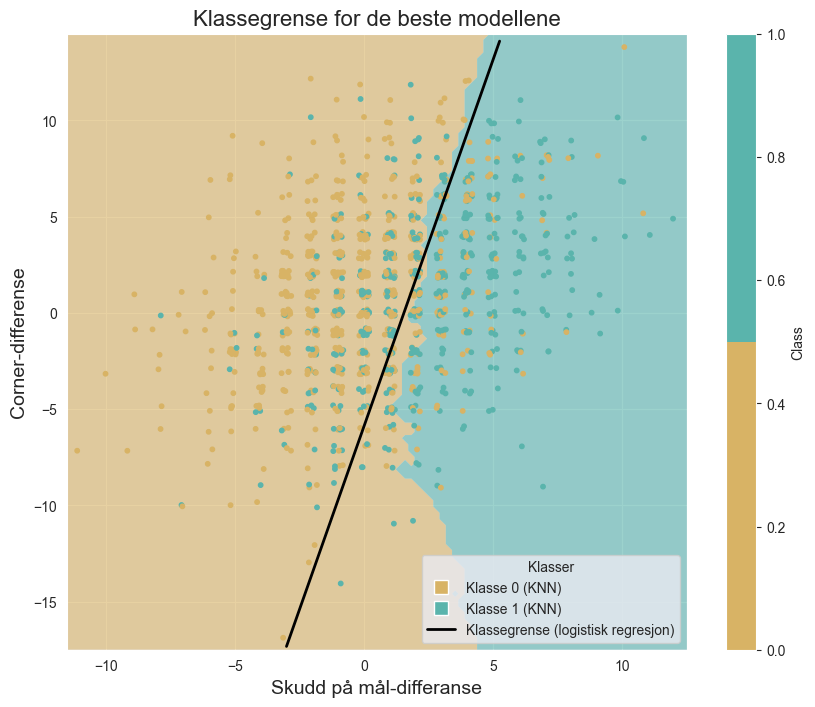

In [59]:
# Plotting av klassegrensene for de beste modellene!

# Set the data to be plotted
n = 100  # Step size

# Function to add jitter to data
def jitter(data, factor=0.2):
    # Add random noise to the data
    return data + np.random.uniform(-factor, factor, data.shape)

# Create a grid for plotting
x_min, x_max = X_tren['skudd_paa_maal_diff'].min() - 0.5, X_tren['skudd_paa_maal_diff'].max() + 0.5
y_min, y_max = X_tren['corner_diff'].min() - 0.5, X_tren['corner_diff'].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

# Create a temporary DataFrame with feature names
temp_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['skudd_paa_maal_diff', 'corner_diff'])

# Predict using the KNeighborsClassifier with temporary feature names
Z_knn = knn.predict(temp_df)

# Reshape Z_knn to match the shape of xx
Z_knn = Z_knn.reshape(xx.shape)

# Plot the class boundary for Logistic Regression
beta0 = resultat.params[0]
beta1 = resultat.params['skudd_paa_maal_diff']
beta2 = resultat.params['corner_diff']
x_lr = np.linspace(-3, 5.25, n)
y_lr = -beta0 / beta2 - x_lr * beta1 / beta2

# Create a custom color map for the plot
cmap = mcolors.ListedColormap(['#d8b365', '#5ab4ac'])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the decision boundaries
ax.contourf(xx, yy, Z_knn, cmap=cmap, alpha=0.6, levels=1, antialiased=True, linestyles='dashed')
ax.plot(x_lr, y_lr, color = "black", label='Logistic Class Boundary', linewidth=2)

# Scatter plot for the training data
jittered_X_tren = jitter(X_tren[['skudd_paa_maal_diff', 'corner_diff']].values)
scatter = ax.scatter(jittered_X_tren[:, 0], jittered_X_tren[:, 1], c=df_tren['y'], cmap=cmap, s=10)
plt.colorbar(scatter, ax=ax, label='Class')

# Add labels and a title
ax.set_xlabel('Skudd på mål-differanse', fontsize=14)
ax.set_ylabel('Corner-differense', fontsize=14)
ax.set_title('Klassegrense for de beste modellene', fontsize=16)

# Create custom legend elements for Klasse 0 and Klasse 1
legend_elements = [
    mlines.Line2D([], [], marker='s', color='w', markerfacecolor='#d8b365', markersize=10, label='Klasse 0 (KNN)', linestyle='None'),
    mlines.Line2D([], [], marker='s', color='w', markerfacecolor='#5ab4ac', markersize=10, label='Klasse 1 (KNN)', linestyle='None'),
    mlines.Line2D([], [], color='black', lw=2, label='Klassegrense (logistisk regresjon)')
]

# Add legend for class boundaries
ax.legend(handles=legend_elements, title="Klasser", loc='lower right')

# Show the plot
plt.show()

[Til toppen.](#top)